In [21]:
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [82]:
fred = pd.read_csv("fred_md.csv")
fred_transforms = fred.iloc[0, :]
fred = fred.iloc[1:, :]

fred["sasdate"] = pd.to_datetime(fred["sasdate"], format="%m/%d/%Y")
fred.index = fred["sasdate"]

fred.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,PERMIT,PERMITNE,PERMITMW,PERMITS,PERMITW,ACOGNO,AMDMNOx,ANDENOx,AMDMUOx,BUSINVx,ISRATIOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,NONREVSL,CONSPI,S&P 500,S&P: indust,S&P div yield,S&P PE ratio,FEDFUNDS,CP3Mx,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,COMPAPFFx,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1959-01-01,1959-01-01,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,38.1504,8.1482,20.1315,12.1386,30.6520,20.8962,19.9176,34.6702,80.1973,1357.0,0.333579,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,291078.0,52478.0,18796.0,713.0,2993.0,14998.0,8740.0,6258.0,33682.0,10774.0,2568.7,5350.3,2418.0,8105.0,39.8,2.5,40.2,1657.0,350.0,452.0,505.0,350.0,NaN,NaN,NaN,NaN,NaN,NaN,14716.48296,NaN,42620.34624,84889.55898,1.560000,138.9,286.6,987.9,50500.0,18.9,18300.0,35.2130,24.9242,48.96116,0.124965,55.62,59.30,3.158342,18.445741,2.48,3.30,2.82,3.09,3.36,4.01,4.02,4.12,4.87,0.82,0.34,0.61,0.88,1.53,1.54,1.64,2.39,NaN,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,29.01,44.8,29.3,21.1,33.3,38.1,22.9,28.9,30.7,29.6,16.042,56.918,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
1959-02-01,1959-02-01,2451.778,2301.5,17.452,294424.7425,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,38.5150,8.2572,20.7690,12.6977,31.1886,21.2804,19.8634,34.1979,81.4428,1421.0,0.358386,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,282958.0,52688.0,18890.0,704.2,2980.0,15115.0,8839.0,6276.0,33798.0,10816.0,2575.4,5381.3,2420.0,8116.0,39.7,2.6,40.3,1667.0,346.0,469.0,508.0,344.0,NaN,NaN,NaN,NaN,NaN,NaN,15400.24873,NaN,43677.15151,85181.81131,1.539338,139.4,287.7,992.1,49800.0,18.6,18100.0,35.2201,25.2270,49.51371,0.125765,54.77,58.33,3.219518,18.418119,2.43,3.26,2.70,3.13,3.54,3.96,3.96,4.14,4.89,0.83,0.27,0.70,1.11,1.53,1.53,1.71,2.46,NaN,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,29.00,44.7,29.4,21.2,33.3,38.1,23.0,28.9,30.7,29.6,16.057,56.951,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
1959-03-01,1959-03-01,2467.594,2318.5,17.617,293418.6704,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,38.3327,8.3464,21.3085,13.1980,31.6572,21.6133,19.9989,35.0637,82.4769,1524.0,0.400947,68068.0,64267.0,5.6,15.3,1459.0,1093.0,1210.0,530.0,680.0,260346.0,53014.0,19069.0,704.1,3013.0,15259.0,8965.0,6294.0,33945.0,10873.0,2584.4,5431.6,2430.0,8132.0,40.0,2.8,40.4,1620.0,330.0,413.0,503.0,374.0,NaN,NaN,NaN,NaN,NaN,NaN,15745.42348,NaN,44781.64655,85620.18980,1.529007,139.7,289.2,998.3,49700.0,18.4,17800.0,35.1304,25.4218,50.00773,0.126123,56.16,59.79,3.151709,18.999351,2.80,3.35,2.80,3.13,3.61,3.99,3.99,4.13,4.85,0.55,0.00,0.33,0.81,1.19,1.19,1.33,2.05,NaN,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,28.97,44.7,29.6,21.3,33.2,38.3,23.0,28.9,30.7,29.6,16.068,57.022,17.785,11.363,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
1959-04-01,1959-04-01,2483.671,2334.9,17.553,299322.8039,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,38.9708,8.5645,21.8970,13.5953,32.6376,22.0742,20.0802,34.9063,83.9922,1589.0,0.444

## Data preprocessing

Macroeconimic notes: 
- **Nonfarm payrolls** - All Employees: Total Nonfarm, commonly known as Total Nonfarm Payroll, is a measure of the number of U.S. workers in the economy that excludes proprietors, private household employees, unpaid volunteers, farm employees, and the unincorporated self-employed.
- **PPI fin goods** - The Producer Price Index is a family of indexes that measures the average change over time in the selling prices received by domestic producers of goods and services. Finished goods are commodities that will not undergo further processing and are ready for sale to the final-demand user, either an individual consumer or business firm. PPIs measure price change from the perspective of the seller
- **PCEPI** - Personal expentiture consumption price index. The PCE price index is known for capturing inflation (or deflation) across a wide range of consumer expenses and reflecting changes in consumer behavior
- **Housing starts** - measure of new residential construction, and are considered a key economic indicator. A housing start is counted as soon as groundbreaking begins, and each unit in a multi-family housing project is treated as a separate housing start.
- **Treasury yield** - Treasury yield is the effective annual interest rate that the U.S. government pays on one of its debt obligations, expressed as a percentage. Put another way, Treasury yield is the annual return investors can expect from holding a U.S. government security with a given maturity. **Note**: Yield is the annual net profit that an investor earns on an investment. The interest rate is the percentage charged by a lender for a loan. The yield on new investments in debt of any kind reflects interest rates at the time they are issued


In [86]:
features_to_names = {
    "RPI": "real_income", 
    "DPCERA3M086SBEA": "real_consumption",
    "INDPRO": "industrial_production_index",
    "CUMFNS": "capacity_utilization",
    "UNRATE": "uneployment_rate",
    "PAYEMS": "nonfarm_payrolls",
    "CES0600000007": "avg_weekly_hours",
    "CES0600000008": "avg_hourly_ernings",
    "WPSFD49207": "ppi_fin_goods",
    "PCEPI": "pcepi",
    "HOUST": "housing_starts",
    "S&P 500": "sp500",
    "EXUSUKx": "us_to_gbt_rate",
    "GS5": "5_year_treasury",
    "GS10": "10_year_treasury",
    "BAAFFM": "baa_corp_bond_rate"
}

In [87]:
def mult_diff_logs(x):
    diff_logs = np.log(x) - np.log(x.shift(1))
    return diff_logs * 1200

def log(x):
    return np.log(x)

def id_transf(x):
    return x

feat_to_transform = {
    "RPI": mult_diff_logs, 
    "DPCERA3M086SBEA": mult_diff_logs,
    "INDPRO": mult_diff_logs,
    "CUMFNS": id_transf,
    "UNRATE": id_transf,
    "PAYEMS": mult_diff_logs,
    "CES0600000007": id_transf,
    "CES0600000008": mult_diff_logs,
    "WPSFD49207": mult_diff_logs,
    "PCEPI": mult_diff_logs,
    "HOUST": log,
    "S&P 500": mult_diff_logs,
    "EXUSUKx": mult_diff_logs,
    "GS5": id_transf,
    "GS10": id_transf,
    "BAAFFM": id_transf
}

TO ADD:
 - **FEDFUNDS** The federal funds rate is one of the most important interest rates in the U.S. economy. That's because it affects monetary and financial conditions, which in turn have a bearing on critical aspects of the broader economy including employment, growth, and inflation.

In [88]:
data = fred[list(features_to_names.keys())].copy()
for f, transf in feat_to_transform.items():
    data[f] = transf(data[f])
data = data.rename(columns=features_to_names)

while pd.isnull(data["real_income"].iloc[-1]):
    data = data.iloc[:-1, :]
while pd.isnull(data["real_income"].iloc[0]):
    data = data.iloc[1:, :]
    
data

,real_income,real_consumption,industrial_production_index,capacity_utilization,uneployment_rate,nonfarm_payrolls,avg_weekly_hours,avg_hourly_ernings,ppi_fin_goods,pcepi,housing_starts,sp500,us_to_gbt_rate,5_year_treasury,10_year_treasury,baa_corp_bond_rate
sasdate,,,,,,,,,,,,,,,,
1959-02-01,4.717681,12.441074,23.276650,81.4428,5.9,4.792430,39.7,5.620619,3.619912,1.121530,7.418781,-18.480300,1.196624,3.96,3.96,2.46
1959-03-01,7.716133,11.292108,17.160628,82.4769,5.6,7.401965,40.0,5.594416,0.000000,0.821790,7.390181,30.074593,1.451441,3.99,3.99,2.05
1959-04-01,7.792945,-4.367363,25.297139,83.9922,5.2,6.929064,40.2,5.568455,0.000000,2.387467,7.371489,19.919228,1.620124,4.12,4.12,1.90
1959-05-01,6.915735,14.406425,17.941550,84.9159,5.1,5.142656,40.3,5.542735,3.609025,0.670620,7.311886,17.938801,-0.852424,4.35,4.31,2.06
1959-06-01,3.722923,4.449943,1.366728,84.7686,5.0,2.931989,40.2,0.000000,-3.609025,3.421773,7.315218,-10.396877,-0.853030,4.50,4.34,1.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,1.572496,3.097908,2.346662,79.0166,3.5,2.736033,40.7,5.530944,7.358508,4.124547,7.289611,-92.352788,-68.301487,3.70,3.52,3.11
2022-10-01,5.915336,3.981924,0.214566,79.2371,3.7,2.527236,40.8,5.928029,9.821429,4.938517,7.262629,-39.431415,1.271411,4.18,3.98,3.18
2022-11-01,2.278048,-3.832829,-6.997138,78.5338,3.6,2.257527,40.4,7.159172,5.877845,1.990872,7.257708,60.122942,41.115952,4.06,3.89,2.32


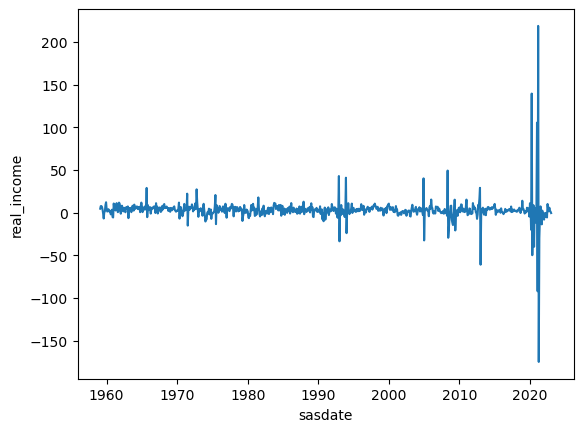

In [73]:
sns.lineplot(x=data["sasdate"], y=data["real_income"]);

## Simple VAR model

In [90]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(data, dates=data.index)

C:\Users\Dzmitry_Kurch\Anaconda3\envs\ds-base\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [92]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Mar, 2023
Time:                     20:27:51
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                    15.7641
Nobs:                     766.000    HQIC:                   13.7964
Log likelihood:          -21674.9    FPE:                    286593.
AIC:                      12.5650    Det(Omega_mle):         145941.
--------------------------------------------------------------------
Results for equation real_income
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                -59.779987        47.469762           -1.259           0.208
L1.real_income                        -0.498494         0.041117          -12.124   